<a href="https://colab.research.google.com/github/Alsa5/ChurnAnalysis/blob/main/ChurnAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CUSTOMER CHURN ANALYSIS USING RANDOM FOREST CLASSIFIER**

**OBJECTIVE**This project focuses on the analysis and prediction of customer attrition for 'ABC
Multinational Bank', a fictional bank, using customer data. The dataset for ABC
Multinational Bank indicates which customers have left, stayed, or signed up for their
service. Multiple important demographics are included for each customer that can help
us identify at-risk customers, pain points, and actions to be taken.

**Data Source**

This dataset about customer information from a fictional bank named 'ABC Multinational Bank' was sourced directly from kaggle.

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'bank-customer-churn-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2445309%2F4139805%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240206%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240206T080710Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D87af7eb80c47e47ac234b6e87d8379444c90677e1b72f538c3d11c0791a5b67783477ba8467564287f8969dfdbe0456320e6ff9627a1bb129a0aed381df7f5ff16ef0a75da900252da5dc189293a439d06f165cce6de73af159efc5dfd234c8183e73ea214251a6522f2364c9211a942aa1b342a5877f582dec50bbe2f9a4a4952c40d61fa6f403edbed068a32a680311d58119157aa544011123c9e9d5cc3d5f32213c0ebc2e12bf370241a35016afdef50b660aac7046f85181717eaf111a2d9302ecb2e3af277bb031d3e48c96a200d38788b72da5be339d2ee788f933817ee27ae10f673cee2ca569d35b116fcd47cc9ff93190583bc43c3f66a927c98f8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 191965 bytes downloaded
Downloaded and uncompressed: bank-customer-churn-dataset
Data source import complete.


**Import Library**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

**Import Data**

In [ ]:
filename = "/kaggle/input/bank-customer-churn-dataset/Bank Customer Churn Prediction.csv"

In [ ]:
df = pd.read_csv(filename)

**Data Description**

This dataset is for ABC Multinational bank with following columns:
* ➢ customer_id, unused variable.
* ➢ credit_score, used as input.
* ➢ country, used as input.
* ➢ gender, used as input.
* ➢ age, used as input.
* ➢ tenure, used as input.
* ➢ balance, used as input.
* ➢ products_number, used as input.
* ➢ credit_card, used as input.
* ➢ active_member, used as input.
* ➢ estimated_salary, used as input.
* ➢ churn, used as the target.
** 1 if the client has left the bank during some period
** 0 if he/she has not left the bank.

In [ ]:
df.head().style.set_properties(**{"border" : "1px solid"})

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.000000,1,1,1,101348.880000,1
1,15647311,608,Spain,Female,41,1,83807.860000,1,0,1,112542.580000,0
2,15619304,502,France,Female,42,8,159660.800000,3,1,0,113931.570000,1
3,15701354,699,France,Female,39,1,0.000000,2,0,0,93826.630000,0
4,15737888,850,Spain,Female,43,2,125510.820000,1,1,1,79084.100000,0


In [ ]:
df.sample(5).style.set_properties(**{"border" : "1px solid"})

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
4201,15621227,668,Germany,Female,46,7,161806.090000,1,1,1,173052.190000,0
1220,15654654,725,Germany,Female,33,7,115182.840000,2,1,1,177279.410000,0
6576,15808905,823,France,Male,37,5,164858.180000,1,1,1,173516.710000,0
7656,15575146,492,Germany,Male,51,8,117808.740000,2,1,1,67311.120000,0
5241,15581526,574,France,Male,41,1,0.000000,2,0,0,70550.000000,0


In [ ]:
df.shape

(10000, 12)

In [ ]:
df.columns

Index(['customer_id', 'credit_score', 'country', 'gender', 'age', 'tenure',
       'balance', 'products_number', 'credit_card', 'active_member',
       'estimated_salary', 'churn'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [ ]:
df.describe().T.style.set_properties(**{"border" : "1px solid"})

,count,mean,std,min,25%,50%,75%,max
customer_id,10000.000000,15690940.569400,71936.186123,15565701.000000,15628528.250000,15690738.000000,15753233.750000,15815690.000000
credit_score,10000.000000,650.528800,96.653299,350.000000,584.000000,652.000000,718.000000,850.000000
age,10000.000000,38.921800,10.487806,18.000000,32.000000,37.000000,44.000000,92.000000
tenure,10000.000000,5.012800,2.892174,0.000000,3.000000,5.000000,7.000000,10.000000
balance,10000.000000,76485.889288,62397.405202,0.000000,0.000000,97198.540000,127644.240000,250898.090000
products_number,10000.000000,1.530200,0.581654,1.000000,1.000000,1.000000,2.000000,4.000000
credit_card,10000.000000,0.705500,0.455840,0.000000,0.000000,1.000000,1.000000,1.000000
active_member,10000.000000,0.515100,0.499797,0.000000,0.000000,1.000000,1.000000,1.000000
estimated_salary,10000.000000,100090.239881,57510.492818,11.580000,51002.110000,100193.915000,149388.247500,199992.480000
churn,10000.000000,0.203700,0.402769,0.000000,0.000000,0.000000,0.000000,1.000000


**Data Preprocessing**

In [ ]:
df.nunique()

customer_id         10000
credit_score          460
country                 3
gender                  2
age                    70
tenure                 11
balance              6382
products_number         4
credit_card             2
active_member           2
estimated_salary     9999
churn                   2
dtype: int64

In [ ]:
df.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [ ]:
df.duplicated().sum()

0

In [ ]:
df['churn'].value_counts()

0    7963
1    2037
Name: churn, dtype: int64

In [ ]:
df_cp = df.copy()

In [ ]:
df_cp = df_cp.drop('customer_id',axis=1)
df_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   country           10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   products_number   10000 non-null  int64  
 7   credit_card       10000 non-null  int64  
 8   active_member     10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  churn             10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


**Data Visualization**

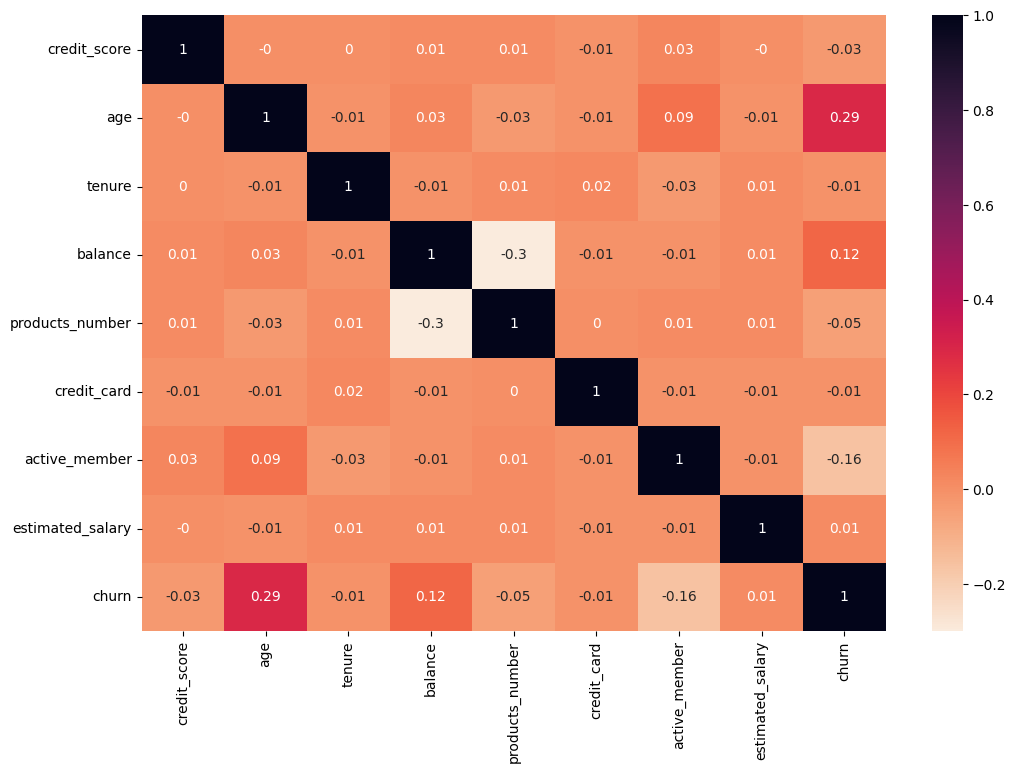

In [ ]:
c_map=sns.color_palette("rocket_r", as_cmap=True)
correlation = df_cp.corr(numeric_only=True).round(2)
plt.figure(figsize = (12,8))
sns.heatmap(correlation, annot = True, cmap = c_map)
plt.show()

In [ ]:
abs(correlation['churn']).sort_values(ascending=False)

churn               1.00
age                 0.29
active_member       0.16
balance             0.12
products_number     0.05
credit_score        0.03
tenure              0.01
credit_card         0.01
estimated_salary    0.01
Name: churn, dtype: float64

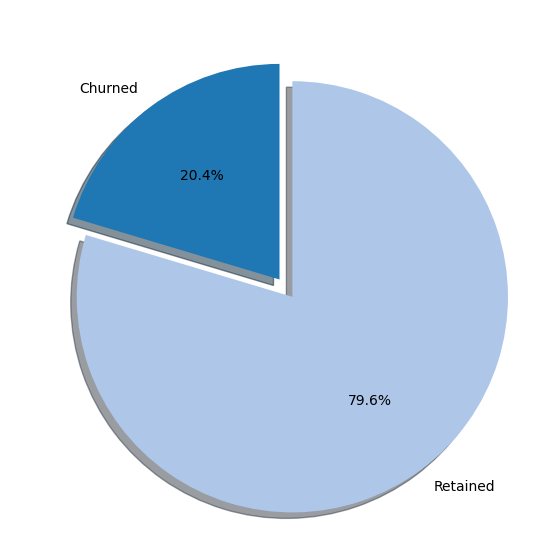

In [ ]:
colors=sns.color_palette("tab20")
labels = 'Churned', 'Retained'
sizes = [df_cp.churn[df_cp['churn']==1].count(), df_cp.churn[df_cp['churn']==0].count()]
explode = (0, 0.1)
plt.figure(figsize=(7,7))
plt.pie(sizes, explode=explode, labels=labels, textprops={'fontsize': 10}, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors)
plt.show()

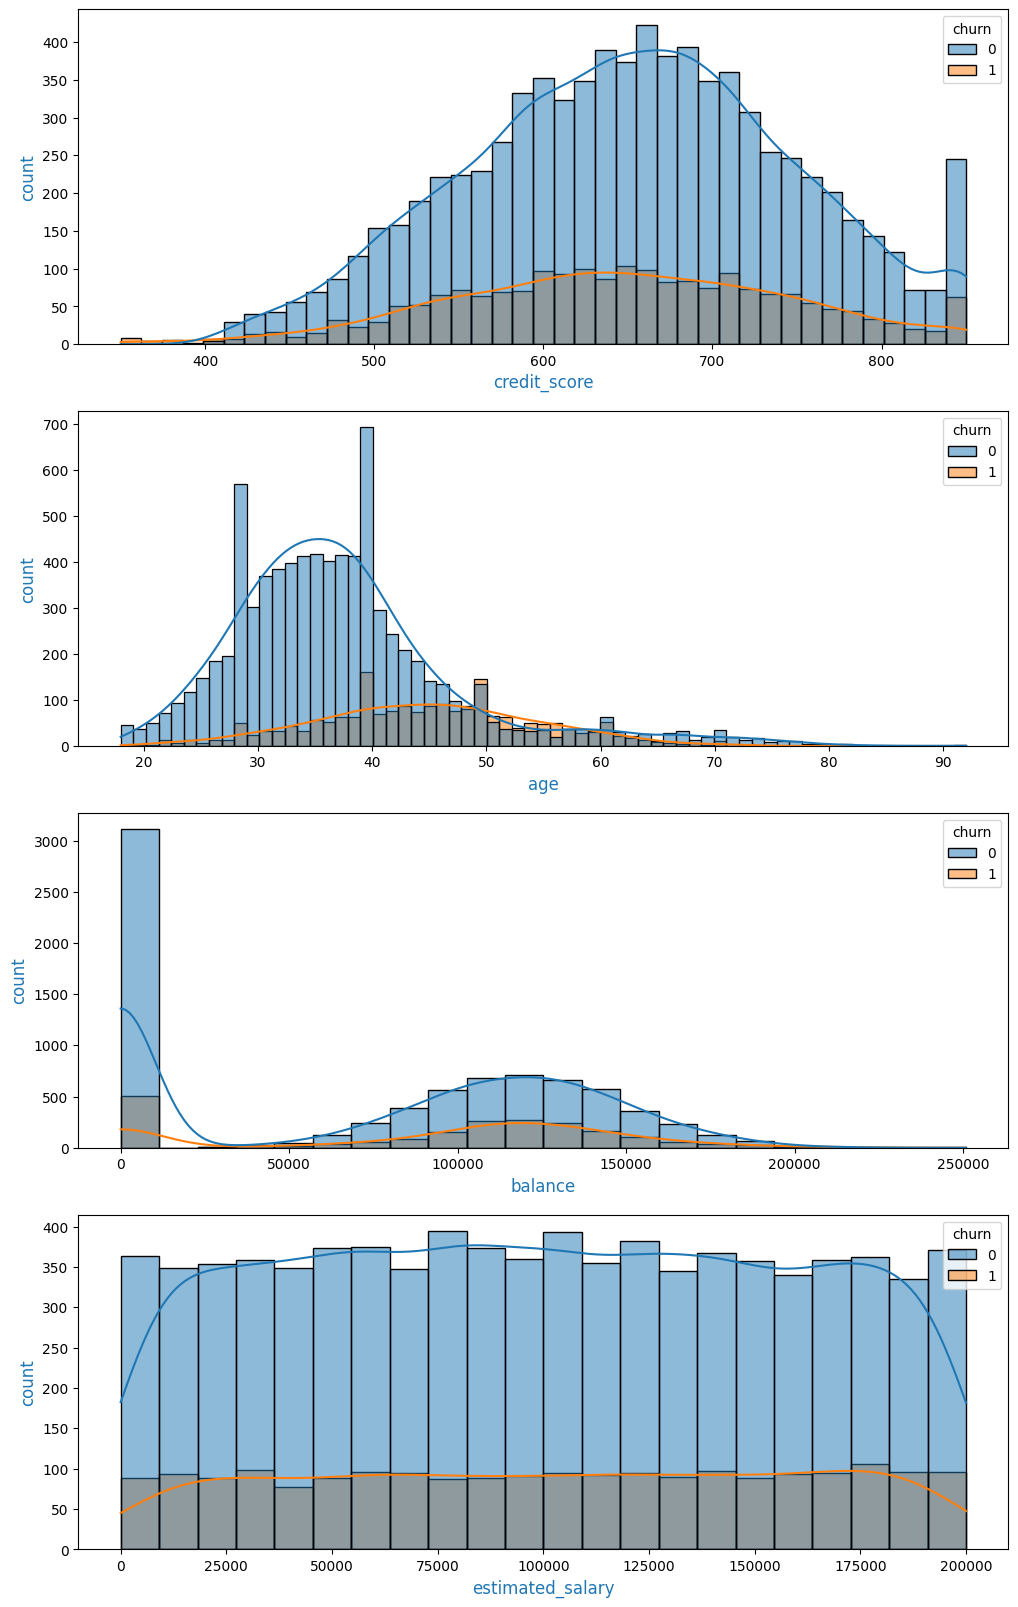

In [ ]:
plt.figure(figsize=(12,20))

plt.subplot(4,1,1)
sns.histplot(df_cp, x='credit_score', hue='churn', kde=True, palette=[colors[0], colors[2]])
plt.xlabel('credit_score', fontsize=12, color=colors[0])
plt.ylabel('count', fontsize=12, color=colors[0])

plt.subplot(4,1,2)
sns.histplot(df_cp, x='age', hue='churn', kde=True, palette=[colors[0], colors[2]])
plt.xlabel('age', fontsize=12, color=colors[0])
plt.ylabel('count', fontsize=12, color=colors[0])

plt.subplot(4,1,3)
sns.histplot(df_cp, x='balance', hue='churn', kde=True, palette=[colors[0], colors[2]])
plt.xlabel('balance', fontsize=12, color=colors[0])
plt.ylabel('count', fontsize=12, color=colors[0])

plt.subplot(4,1,4)
sns.histplot(df_cp, x='estimated_salary', hue='churn', kde=True, palette=[colors[0], colors[2]])
plt.xlabel('estimated_salary', fontsize=12, color=colors[0])
plt.ylabel('count', fontsize=12, color=colors[0])

plt.show()

<ipython-input-21-4733c3c90f34>:4: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  cplot = sns.countplot(data=df_cp, x='country', hue='churn', order=df_cp['country'].value_counts().index, palette=colors)
<ipython-input-21-4733c3c90f34>:11: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  cplot = sns.countplot(data=df_cp, x='gender', hue='churn', order=df_cp['gender'].value_counts().index, palette=colors)
<ipython-input-21-4733c3c90f34>:18: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  cplot = sns.countplot(data=df_cp, x='credit_card', hue='churn', order=df_cp['credit_card'].value_counts().index, palette=colors)
<ipython-input-21-4733c3c90f34>:25: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  cplot = sns.countplot(data=df_cp, x='active_member', hue='churn', order=df_cp['active_member'].value

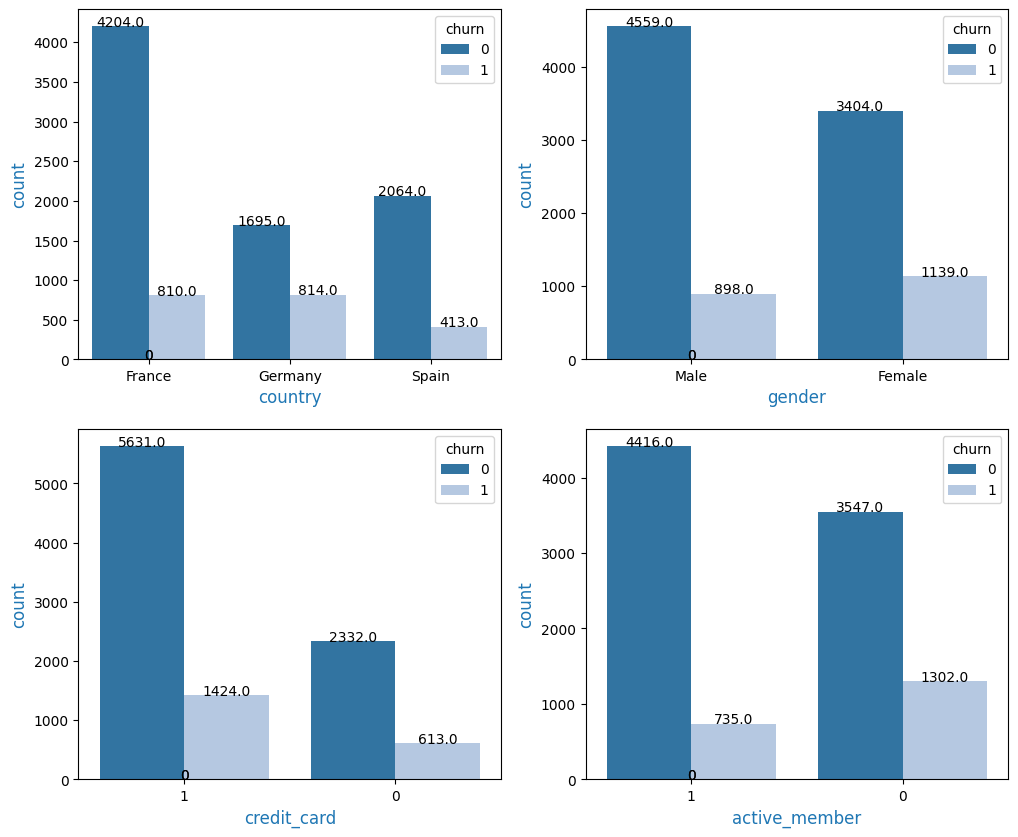

In [ ]:
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
cplot = sns.countplot(data=df_cp, x='country', hue='churn', order=df_cp['country'].value_counts().index, palette=colors)
plt.xlabel('country', fontsize=12, color=colors[0])
plt.ylabel('count', fontsize=12, color=colors[0])
for x in cplot.patches:
  cplot.text (x.get_x() + x.get_width()  / 2, x.get_height()+ 0.75, x.get_height(), horizontalalignment='center', fontsize = 10)

plt.subplot(2,2,2)
cplot = sns.countplot(data=df_cp, x='gender', hue='churn', order=df_cp['gender'].value_counts().index, palette=colors)
plt.xlabel('gender', fontsize=12, color=colors[0])
plt.ylabel('count', fontsize=12, color=colors[0])
for x in cplot.patches:
  cplot.text (x.get_x() + x.get_width()  / 2, x.get_height()+ 0.75, x.get_height(), horizontalalignment='center', fontsize = 10)

plt.subplot(2,2,3)
cplot = sns.countplot(data=df_cp, x='credit_card', hue='churn', order=df_cp['credit_card'].value_counts().index, palette=colors)
plt.xlabel('credit_card', fontsize=12, color=colors[0])
plt.ylabel('count', fontsize=12, color=colors[0])
for x in cplot.patches:
  cplot.text (x.get_x() + x.get_width()  / 2, x.get_height()+ 0.75, x.get_height(), horizontalalignment='center', fontsize = 10)

plt.subplot(2,2,4)
cplot = sns.countplot(data=df_cp, x='active_member', hue='churn', order=df_cp['active_member'].value_counts().index, palette=colors)
plt.xlabel('active_member', fontsize=12, color=colors[0])
plt.ylabel('count', fontsize=12, color=colors[0])
for x in cplot.patches:
  cplot.text (x.get_x() + x.get_width()  / 2, x.get_height()+ 0.75, x.get_height(), horizontalalignment='center', fontsize = 10)

plt.show()

<ipython-input-22-752b6dead3fb>:3: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  cplot = sns.countplot(data=df_cp, x='products_number', hue='churn', palette=colors)


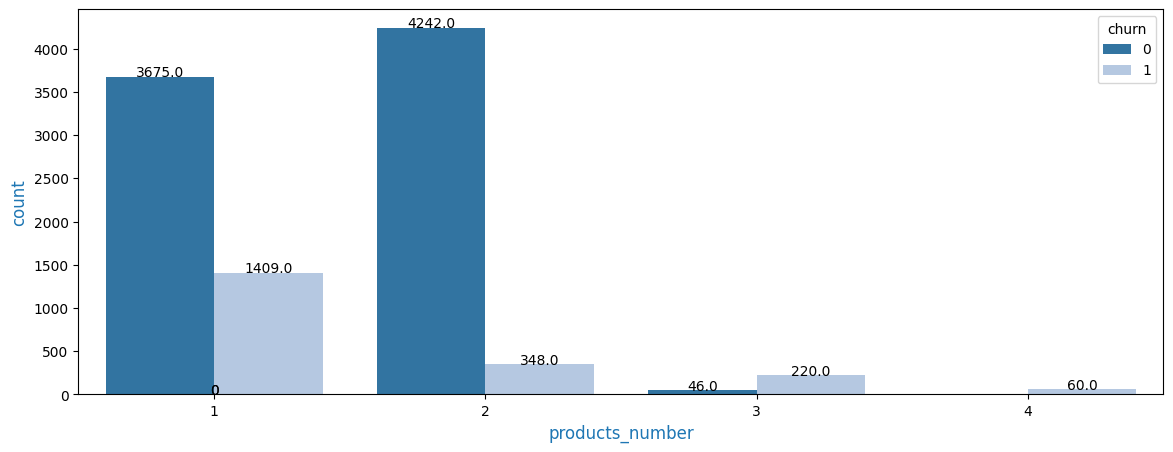

In [ ]:
plt.figure(figsize=(14,5))

cplot = sns.countplot(data=df_cp, x='products_number', hue='churn', palette=colors)
plt.xlabel('products_number', fontsize=12, color=colors[0])
plt.ylabel('count', fontsize=12, color=colors[0])
for x in cplot.patches:
  cplot.text (x.get_x() + x.get_width()  / 2, x.get_height()+ 0.75, x.get_height(), horizontalalignment='center', fontsize = 10)

plt.show()

<ipython-input-23-70cd45e3a395>:3: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  cplot = sns.countplot(data=df_cp, x='tenure', hue='churn', palette=colors)


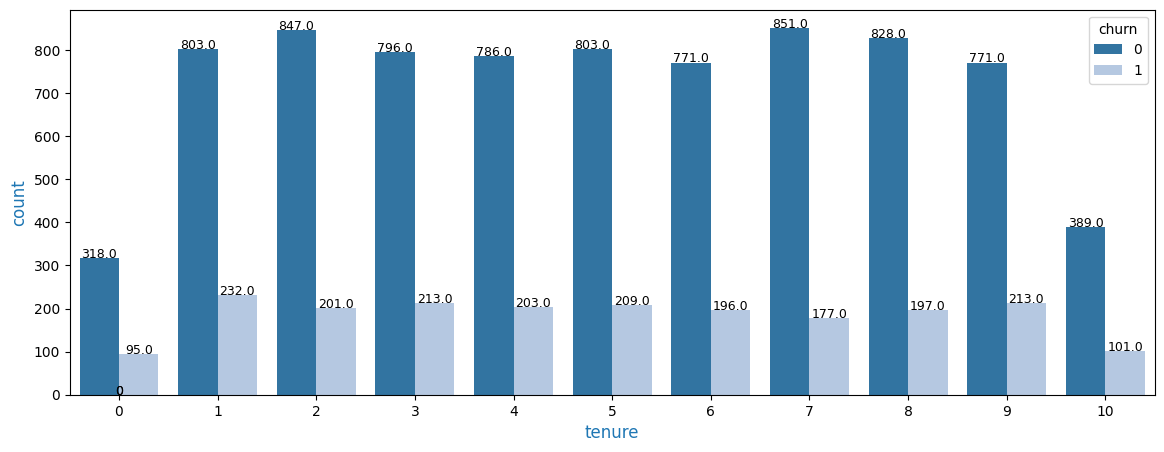

In [ ]:
plt.figure(figsize=(14,5))

cplot = sns.countplot(data=df_cp, x='tenure', hue='churn', palette=colors)
plt.xlabel('tenure', fontsize=12, color=colors[0])
plt.ylabel('count', fontsize=12, color=colors[0])
for x in cplot.patches:
  cplot.text (x.get_x() + x.get_width()  / 2, x.get_height()+ 0.75, x.get_height(), horizontalalignment='center', fontsize = 9)

plt.show()

In [ ]:
dfEnc=df_cp.copy()

In [ ]:
dfEnc["gender"] = LabelEncoder().fit_transform(dfEnc["gender"])
dfEnc["country"] = LabelEncoder().fit_transform(dfEnc["country"])

**Defining Target Variable (y) and Feature Variables (X)**

In [ ]:
X=dfEnc.drop('churn',axis=1)
X.head().style.set_properties(**{"border" : "1px solid"})

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
0,619,0,0,42,2,0.000000,1,1,1,101348.880000
1,608,2,0,41,1,83807.860000,1,0,1,112542.580000
2,502,0,0,42,8,159660.800000,3,1,0,113931.570000
3,699,0,0,39,1,0.000000,2,0,0,93826.630000
4,850,2,0,43,2,125510.820000,1,1,1,79084.100000


In [ ]:
Y=dfEnc['churn']
Y.head()

0    1
1    0
2    1
3    0
4    0
Name: churn, dtype: int64

In [ ]:
X_bal,Y_bal=SMOTE().fit_resample(X,Y)

In [ ]:
Y_bal.value_counts()

1    7963
0    7963
Name: churn, dtype: int64

**Train Test Split**

In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(X_bal,Y_bal,test_size=0.2,random_state=42)

In [ ]:
print("X_bal shape : ", X_bal.shape)
print("X_train shape : ", X_train.shape)
print("X_test shape : ", X_test.shape)
print("Y_bal shape : ", Y_bal.shape)
print("Y_train shape : ", Y_train.shape)
print("Y_test shape : ", Y_test.shape)

X_bal shape :  (15926, 10)
X_train shape :  (12740, 10)
X_test shape :  (3186, 10)
Y_bal shape :  (15926,)
Y_train shape :  (12740,)
Y_test shape :  (3186,)


**Modeling**

In [ ]:
rf = RandomForestClassifier(n_jobs=-1, verbose=2)

In [ ]:
rf.fit(X_train, Y_train)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100building tree 24 of 100

building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    1.0s


building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100building tree 82 of 100

building tree 83

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


RandomForestClassifier(n_jobs=-1, verbose=2)

**Model Evaluation**

In [ ]:
Y_pred = rf.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


In [ ]:
print(metrics.classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86      1633
           1       0.85      0.88      0.86      1553

    accuracy                           0.86      3186
   macro avg       0.86      0.86      0.86      3186
weighted avg       0.86      0.86      0.86      3186



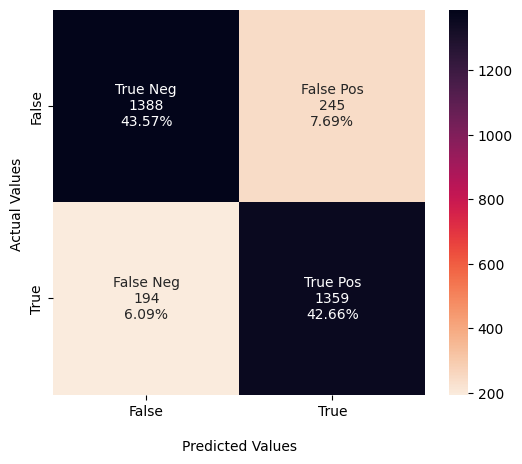

In [ ]:
cf_matrix = metrics.confusion_matrix(Y_test, Y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(6,5))
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap=c_map)
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

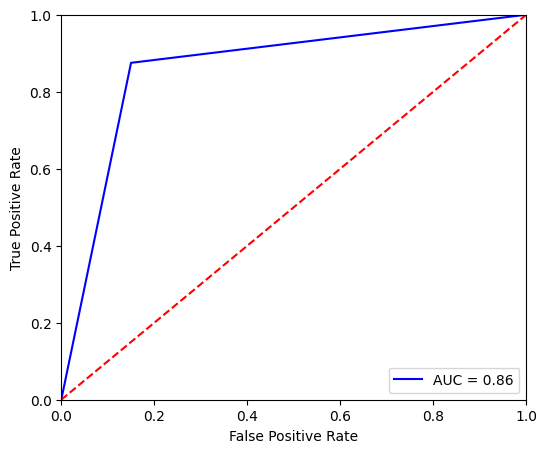

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(Y_test, Y_pred)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Prediction**

In [ ]:
sample = [[400, 1, 0, 50, 3, 500.00, 1, 1, 0, 200000.00]]
sample_df = pd.DataFrame(sample, columns=['credit_score', 'country', 'gender', 'age', 'tenure', 'balance'	,'products_number' ,'credit_card',	'active_member'	,'estimated_salary'])
print("Sample input:- \n")
display(sample_df.style.set_properties(**{"border" : "1px solid"}))
print("\n\nPredicted value:- \n")
pred = rf.predict(sample_df)
if pred[0] == 1:
  print("Customer is likely to leave\n")
else:
  print("Customer is likely to stay\n")

Sample input:- 



,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
0,400,1,0,50,3,500.000000,1,1,0,200000.000000




Predicted value:- 

Customer is likely to leave



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


**Explanation**

What is Churn Analysis?

Customer churn analysis is the process of using your churn data to understand:
* Which customers are leaving?
* Why are they leaving?
* Which customers are likely to churn shortly?
* What can you do to reduce churn?


What is Churn Prediction?

Churn prediction means detecting which customers are likely to leave a service or to
cancel a subscription to a service. It is a critical prediction for many businesses because
acquiring new clients often costs more than retaining existing ones. Once you can
identify those customers that are at risk of canceling, you should know exactly what
marketing action to take for each individual customer to maximize the chances that the
customer will remain.

What is Random Forest Algorithm?

"Random Forest is a classifier that contains a number of decision trees on various
subsets of the given dataset and takes the average to improve the predictive
accuracy of that dataset." Instead of relying on one decision tree, the random forest
takes the prediction from each tree and based on the majority votes of predictions, and it
predicts the final output.

Hence an ML model for Churn analysis and prediction for ABC Multinational Bank was created using Random Forest Algorithm, which has fetched an accuracy of about 86%.